# Домашнее задание

# 1 - Уменьшение палитры изображения (суммарно 6 баллов)
Для <a href='https://thumbs.dreamstime.com/x/two-lorikeet-birds-2293918.jpg'> картинки </a> нужно уменьшить число цветов в палитре.

Для этого нужно выделить **кластеры в пространстве RGB**, объекты соответствуют пикселям изображения. После выделения кластеров, все пиксели, отнесенные в один кластер, заполняются одним цветом; этот цвет может быть центроидом соответствующего кластера, медианным цветом по кластеру.

Попробуйте различные алгоритмы кластеризации:

* KMeans
* DBSCAN
* AgglomerativeClustering

Рассмотрите число кластеров K = 2, 3, 10, 20 (в алгоритмах, где есть такой гиперпараметр).

Для различных кластеризаций оцените и сравните потери от уменьшения цветов при помощи метрики 
<a href='http://scikit-image.org/docs/dev/api/skimage.measure.html#skimage.measure.compare_ssim'> SSIM </a>. Какой способ оказался лучшим?

Задание оценивает в 5 баллов.

Еще 1 балл даётся за запуск алгоритма на выбранных вами картинках - на них результат должен получиться красивым.

Вот вам вспомогательные функции для считывания и вывода изображений:

In [1]:
import matplotlib.pyplot as plt
import cv2 # нужно поставить себе cv2 через conda install opencv

def draw_picture(image, bgr=False):
    b, g, r = cv2.split(image) # по умолчанию cv2 почему-то отдает цвета в порядке BGR вместо RGB
    new_image = cv2.merge([r, g, b])
    plt.figure(figsize=(7, 5))
    plt.axis('off')
    plt.imshow(new_image)
    plt.show()

img - это обычный трехмерный массив цветов пикселей, где две первые координаты - это координаты каждого пикселя, и третья обозначает R, G или B.

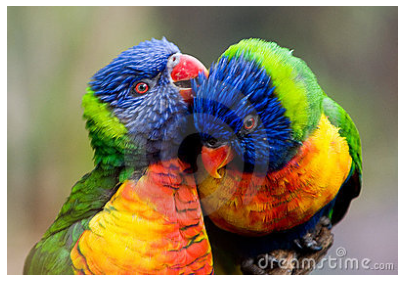

In [2]:
img = cv2.imread('birds.jpg') # считать картинку
draw_picture(img) # нарисовать картинку

In [3]:
print(img.shape) # сам img - это обычный трехмерный массив 275 x 400 x 3
# вам скорее все кстати понадобится сделать reshape, чтобы перейти от 275x400 к одномерному массиву пикселей

(275, 400, 3)


In [4]:
img[0]

array([[116, 150, 140],
       [115, 149, 139],
       [113, 147, 137],
       ...,
       [ 96, 108, 108],
       [ 97, 109, 111],
       [ 97, 109, 111]], dtype=uint8)

### Выполнение

In [20]:
import numpy as np
from sklearn.cluster import DBSCAN, KMeans, AgglomerativeClustering
from skimage.metrics import structural_similarity as ssim

In [6]:
def kmeans_clustering(original_img, optimizer=False, display=False):
    print('Kmeans clustering:')
    print(f'\tOptimizer={optimizer}')
    print(f'\tDisplay mode={display}')
    image = original_img.reshape(-1, 3)
    height, width, deep = original_img.shape
    if optimizer:
        ssim_errors = []
        k_params = [2, 3, 10, 30]
        for k in k_params:
            kmeans = KMeans(n_clusters=k, random_state=42).fit(image)
            kmeans_img = kmeans.predict(image) 
            color_clusters = np.array(kmeans.cluster_centers_, dtype=np.int64)
            kmeans_img = np.array(list(map(lambda x: color_clusters[x], kmeans_img))).reshape(height, width, deep)
            ssim_metric = ssim(original_img, kmeans_img, data_range=original_img.max() - original_img.min(), multichannel=True)
            ssim_errors.append((k, ssim_metric))
            
            if display:
                print(f'n_clusters={k}, ssim_metric={ssim_metric}')
                draw_picture(kmeans_img)
        
        
        return {n: metric for n, metric in ssim_errors}
    
    kmeans = KMeans(n_clusters=3, random_state=42).fit(image)
    kmeans_img = kmeans.predict(image)
    color_clusters = np.array(kmeans.cluster_centers_, dtype=np.int64)
    kmeans_img = np.array(list(map(lambda x: color_clusters[x], kmeans_img))).reshape(275, 400, 3)
    ssim_score = ssim(original_img, kmeans_img, data_range=original_img.max() - original_img.min(), multichannel=True)
    
    if display:
        print(f'n_clusters={5}, ssim_metric={ssim_score}')
        draw_picture(kmeans_img)
    
    return (5, ssim_score)
    

Kmeans clustering:
	Optimizer=True
	Display mode=True
n_clusters=2, ssim_metric=0.5328571832868024


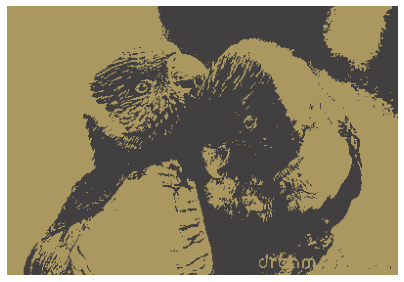

n_clusters=3, ssim_metric=0.5635002444140094


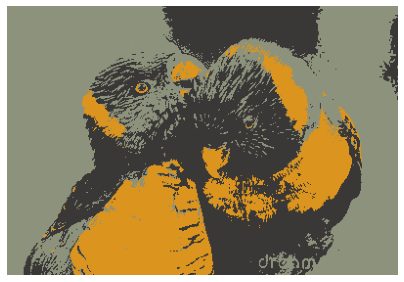

n_clusters=10, ssim_metric=0.6789252297134936


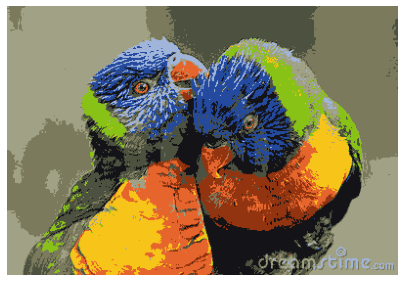

n_clusters=30, ssim_metric=0.7874950650560507


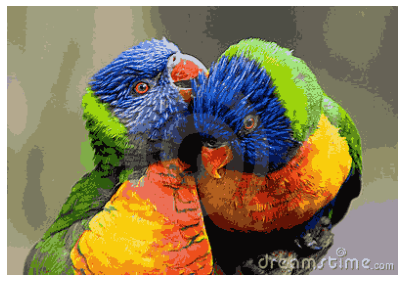

In [7]:
kmeans_ssim_score = kmeans_clustering(original_img=img, optimizer=True, display=True)

In [8]:
def db_clustering(original_img, optimizer=False, display=False):
    print('DBSCAN clustering:')
    print(f'\tOptimizer={optimizer}')
    print(f'\tDisplay mode={display}')
    image = original_img.reshape(-1, 3)
    height, width, deep = original_img.shape
    if optimizer:
        ssim_errors = []
        samples = [5, 3, 1]
        for sample in samples:
            db_img = DBSCAN(eps=1e-2, min_samples=sample).fit_predict(image)
            db_img_unique = np.unique(db_img) # Количество кластеров на которые моделька разделила наши пиксели
            colormap = {cluster: np.median(image[db_img == cluster], axis=0).astype(int) for cluster in db_img_unique}
            db_img = np.array(list(map(lambda x: colormap[x], db_img))).reshape(height, width, deep)
            ssim_score = ssim(original_img, db_img, data_range=original_img.max() - original_img.min(), multichannel=True)
            ssim_errors.append((sample, ssim_score))
            
            if display:
                print(f'min_samples={sample}, ssim={ssim_score}, eps={1e-2}')
                draw_picture(db_img)
        
        return ssim_errors
            
    db_img = DBSCAN(min_samples=1, eps=1e-2).fit_predict(image)
    db_img_unique = np.unique(db_img)
    colormap = {cluster: np.median(image[db_img == cluster], axis=0).astype(int) for cluster in db_img_unique}
    db_img = np.array(list(map(lambda x: colormap[x], db_img))).reshape(275, 400, 3)
    ssim_score = ssim(original_img, db_img, data_range=original_img.max() - original_img.min(), multichannel=True)
    
    if display:
        print(f'min_samples={5}, ssim={ssim_score}')
        draw_picture(db_img)
    
    return (5, ssim_score)
    

DBSCAN clustering:
	Optimizer=False
	Display mode=True
min_samples=5, ssim=1.0


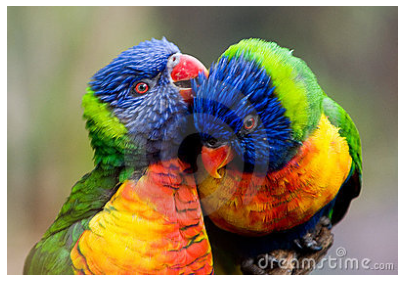

In [9]:
db_ssim_score = db_clustering(img, optimizer=False, display=True)

In [16]:
def agglomerative_clustering(original_img, optimizer=False, display=False):
    print('Agglomerative clustering:')
    print(f'\tOptimizer={optimizer}')
    print(f'\tDisplay mode={display}')
    original_img = cv2.resize(original_img, (0, 0), fx=0.5, fy=0.5)
    image = original_img
    height, width, deep = image.shape
    image = image.reshape(-1, 3)
    if optimizer:
        ssim_errors = []
        clusters = [2, 3, 10, 20]
        for n_clusters in clusters:
            agglo_img = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward').fit_predict(image)
            agglo_img_unique = np.unique(agglo_img)
            colormap = {cluster: np.median(image[agglo_img == cluster], axis=0).astype(int) for cluster in agglo_img_unique}
            agglo_img = np.array(list(map(lambda x: colormap[x], agglo_img))).reshape(height, width, deep)
            ssim_score = ssim(original_img, agglo_img, data_range=original_img.max() - original_img.min(), multichannel=True)
            ssim_errors.append((n_clusters, ssim_score))
            
            if display:
                print(f'n_clusters={n_clusters}, ssim={ssim_score}')
                draw_picture(agglo_img)
        
        return ssim_errors
            
    agglo_img = AgglomerativeClustering(n_clusters=5, linkage='ward').fit_predict(image)
    agglo_img_unique = np.unique(agglo_img)
    colormap = {cluster: np.median(image[agglo_img == cluster], axis=0).astype(int) for cluster in agglo_img_unique}
    agglo_img = np.array(list(map(lambda x: colormap[x], agglo_img))).reshape(height, width, deep)
    ssim_score = ssim(original_img, agglo_img, data_range=original_img.max() - original_img.min(), multichannel=True)
    
    if display:
        print(f'n_clusters={5}, ssim={ssim_score}')
        draw_picture(agglo_img)
    
    return (5, ssim_score)
    

Agglomerative clustering:
	Optimizer=False
	Display mode=True
n_clusters=5, ssim=0.602796330906443


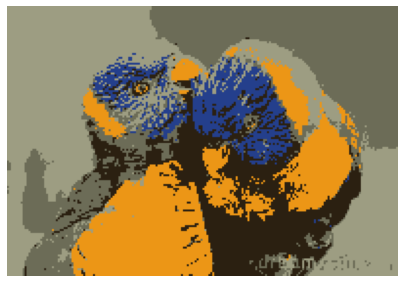

In [11]:
ssim_agglo_score = agglomerative_clustering(img, optimizer=False, display=True)

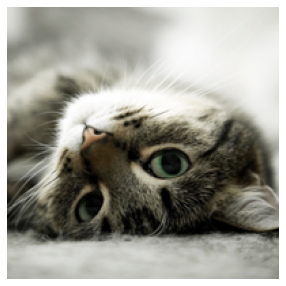

In [12]:
own_img = cv2.imread('cat.png') # считать картинку
draw_picture(own_img) # нарисовать картинку

Kmeans clustering:
	Optimizer=True
	Display mode=True
n_clusters=2, ssim_metric=0.5138049625227064


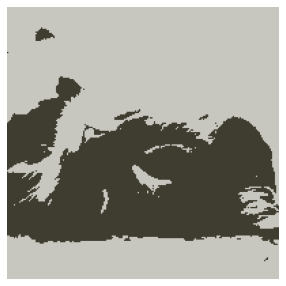

n_clusters=3, ssim_metric=0.5833778653869474


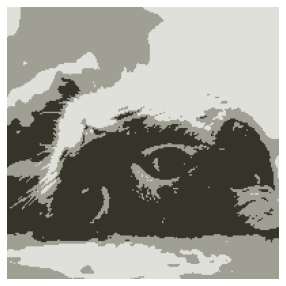

n_clusters=10, ssim_metric=0.8690875929442429


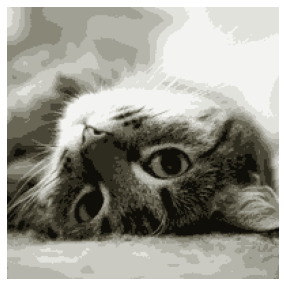

n_clusters=30, ssim_metric=0.9686621726618223


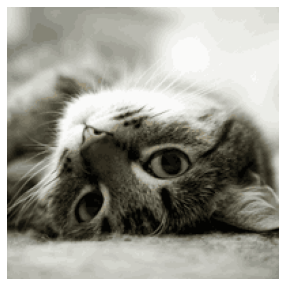

In [13]:
own_ssim_kmeans_score = kmeans_clustering(own_img, optimizer=True, display=True)

DBSCAN clustering:
	Optimizer=True
	Display mode=True
min_samples=5, ssim=0.22880686524588675, eps=0.01


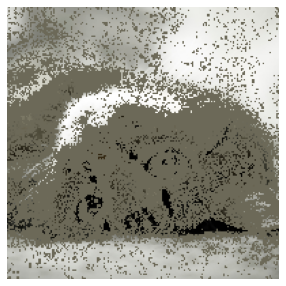

min_samples=3, ssim=0.3436539490597887, eps=0.01


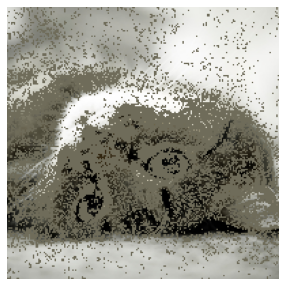

min_samples=1, ssim=1.0, eps=0.01


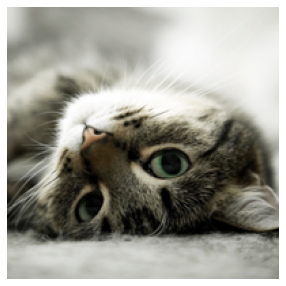

In [14]:
own_ssim_db_score = db_clustering(own_img, optimizer=True, display=True)

Agglomerative clustering:
	Optimizer=True
	Display mode=True
n_clusters=2, ssim=0.48558243742209717


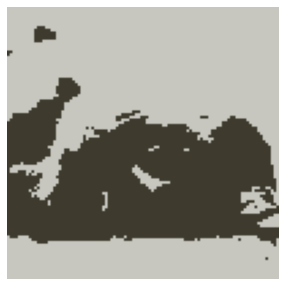

n_clusters=3, ssim=0.5482472173461092


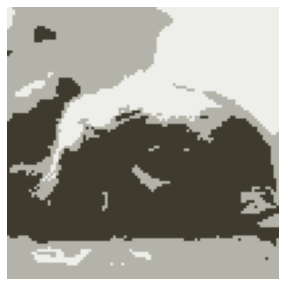

n_clusters=10, ssim=0.8975707535404872


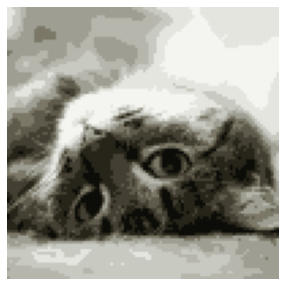

n_clusters=20, ssim=0.9617823238330131


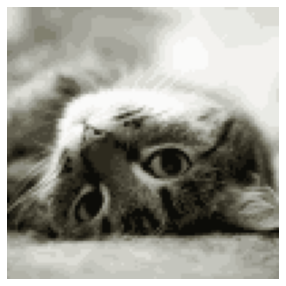

In [17]:
own_ssim_agglo_score = agglomerative_clustering(own_img, optimizer=True, display=True)

## Вывод: лучшим оказалась кластеризация с помощью DBSCAN, удалось добиться SSIM=1.0. Думаю, что и в других методах при увеличении количества кластеров до количества цветов source картинки можно получить аналогичный результат.

# 2 - Уменьшение размерности помогает классификации лиц (суммарно 6 баллов)

Используя методы уменьшения размерности признаков, решите с максимальным **accuracy** задачу классификации лиц знаменитостей (датасет старый, неудивительно, если вы из всех знаменитостей будете знать только Буша и Шварценнегера).

Попробуйте добиться максимального accuracy (2 балла)
* без уменьшения размерности
* с уменьшением размерности

Возможно без уменьшения размерности у вас даже просто не получится дождаться времени работы на 11750 признаках. Я слышал у кого-то получилось, у меня нет.

Сравните ваш результат с константным предсказанием "всегда самый популярный класс". Делает ли ваша модель какой-то значительный прогресс? (1 балл)

Нарисуйте несколько лиц, на которых ваш алгоритм ошибся, подпишите правильный ответ и ваш ответ. (1 балл)

Напишите, каким алгоритмом вы воспользовались (PCA или TSNE), почему не другим? Обоснуйте ответ. (1 балл)

Визуализируйте датасет на плоскости. Подпишите несколько самых больших классов именами людей. Чем вы воспользуетесь, PCA или TSNE? Обоснуйте ответ (1 балл)

Скачивание данных и вспомогательная функция визуализации лиц уже есть:

In [332]:
import warnings
warnings.filterwarnings("ignore")

from sklearn.datasets import fetch_lfw_people
lfw_people = fetch_lfw_people(min_faces_per_person=30, resize=1.0)
# эту строчку менять нельзя, ресайзить нельзя

In [333]:
from sklearn.model_selection import train_test_split
X = lfw_people.data
y = lfw_people.target
names = lfw_people.target_names

In [334]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2, random_state=42)
# эту строчку тоже менять нельзя'

In [19]:
X.shape # 2370 лиц, каждый из них представляется вектором размера 11750

(2370, 11750)

In [7]:
y.shape

(2370,)

In [8]:
import numpy as np

uniq_targets = np.unique(y)
uniq_targets

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33],
      dtype=int64)

In [9]:
names[8] # в y лежат номера, а names переводит номер в имя

'George W Bush'

In [10]:
lfw_people.keys()

dict_keys(['data', 'images', 'target', 'target_names', 'DESCR'])

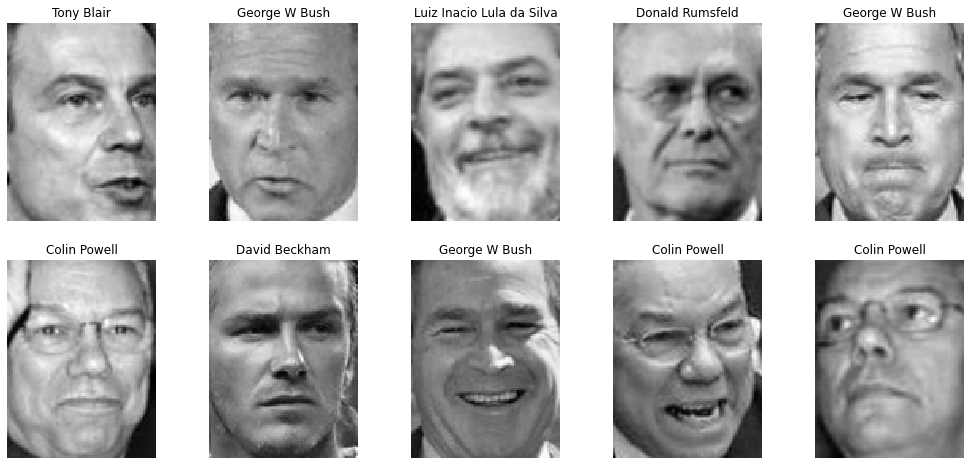

In [271]:
import matplotlib.pyplot as plt
def plot_image(image_id):
    # функция рисует изображение номер image_id
    plt.title(names[y[image_id]])
    plt.imshow(255 - lfw_people['images'][image_id], cmap=plt.cm.gray_r, interpolation='nearest')
    
def plot_grid(image_ids, nrows, ncols):
    # функция рисует изображения с id равными image_ids
    # в nrows рядов и ncols столбцов
    fig = plt.gcf()
    fig.set_size_inches(17.5, 8)
    for index, example_id in enumerate(image_ids):
        plt.subplot(nrows, ncols, index + 1)
        plot_image(example_id)
        plt.axis('off')

plot_grid(range(50, 60), nrows=2, ncols=5)# первые 10 лиц

In [12]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score

In [344]:
def draw_picture(y_test, y_pred, n_pictures):
    positions = np.where(y_test != y_pred)[0][:n_pictures]
    fig = plt.gcf()
    fig.set_size_inches(5, 8)
    for idx, pos in enumerate(positions):
        fig, ax = plt.subplots(1, 2)
        ax[0].set_title(f'Real={names[y_test[pos]]}')
        ax[0].imshow(255 - X_test[pos].reshape(125, 94), cmap=plt.cm.gray_r, interpolation='nearest')
        ax[1].set_title(f'Predict={names[y_pred[pos]]}')
        ax[1].imshow(255 - X_test[pos].reshape(125, 94), cmap=plt.cm.gray_r, interpolation='nearest')


## Без уменьшения размерности:

### Logistic Regression

In [23]:
from sklearn.linear_model import LogisticRegression

In [41]:
clf = make_pipeline(MinMaxScaler(), LogisticRegression(C=1e-1)) # Используем MinMaxScaler, при использовании StandardScaler получали score на train = 1, что не есть хорошо
clf.fit(X_train, y_train)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('logisticregression', LogisticRegression(C=0.1))])

In [44]:
y_pred_train = clf.predict(X_train)
lr_train_acc = accuracy_score(y_train, y_pred_train)

print(f'Logistic Regression(C=1e-1):\n\ttrain_accuracy={lr_train_acc}')

Logistic Regression(C=1e-1):
	train_accuracy=0.9625527426160337


In [45]:
y_pred_test = clf.predict(X_test)
lr_test_acc = accuracy_score(y_test, y_pred_test)

print(f'Logistic Regression(C=1e-1):\n\ttest_accuracy={lr_test_acc}')

Logistic Regression(C=1e-1):
	test_accuracy=0.7257383966244726


In [46]:
# Можем наблюдать уже неплохой скор, попробуем другие модели

### DecisionTree

In [49]:
from sklearn.tree import DecisionTreeClassifier

In [111]:
clf = make_pipeline(MinMaxScaler(), DecisionTreeClassifier(max_depth=30, random_state=42))
clf.fit(X_train, y_train)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(max_depth=30, random_state=42))])

In [112]:
tree_pred = clf.predict(X_train)
train_tree_acc = accuracy_score(y_train, tree_pred)

print(f'DecisionTreeClassifier(max_depth=100):\n\ttrain_accuracy={train_tree_acc}')

DecisionTreeClassifier(max_depth=100):
	train_accuracy=0.9963080168776371


In [113]:
tree_pred = clf.predict(X_test)
test_tree_acc = accuracy_score(y_test, tree_pred)

print(f'DecisionTreeClassifier(max_depth=100):\n\ttest_accuracy={test_tree_acc}')

DecisionTreeClassifier(max_depth=100):
	test_accuracy=0.29324894514767935


### SVM

In [114]:
from sklearn.svm import SVC

In [122]:
clf = make_pipeline(StandardScaler(), SVC(degree=5))
clf.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()), ('svc', SVC(degree=5))])

In [123]:
svc_pred = clf.predict(X_train)
train_svc_acc = accuracy_score(y_train, svc_pred)

print(f'SVC:\n\ttrain_accuracy={train_svc_acc}')

SVC:
	train_accuracy=0.8602320675105485


In [125]:
svc_pred = clf.predict(X_test)
test_svc_acc = accuracy_score(y_test, svc_pred)

print(f'SVC:\n\ttest_accuracy={test_svc_acc}')

SVC:
	test_accuracy=0.5675105485232067


### Кажется, что мы остановимся на Logistic Regression

In [319]:
Cs = [1e-3, 1e-2, 1e-1, 1, 2, 3]
errors = []
for C in Cs:
    clf = make_pipeline(MinMaxScaler(), LogisticRegression(C=C))
    clf.fit(X_train, y_train)
    train_pred = clf.predict(X_train)
    test_pred = clf.predict(X_test)
    errors.append((C, accuracy_score(y_test, test_pred), accuracy_score(y_train, train_pred)))
    
best_c, best_test, best_train = max(errors, key=lambda x: x[1])
clf = make_pipeline(MinMaxScaler(), LogisticRegression(C=best_c))
print(clf.fit(X_train, y_train))
print(f'train accuracy={accuracy_score(y_train, clf.predict(X_train))}')
print(f'test accuracy={accuracy_score(y_test, clf.predict(X_test))}')

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('logisticregression', LogisticRegression(C=0.1))])
train accuracy=0.9625527426160337
test accuracy=0.7257383966244726


<Figure size 360x576 with 0 Axes>

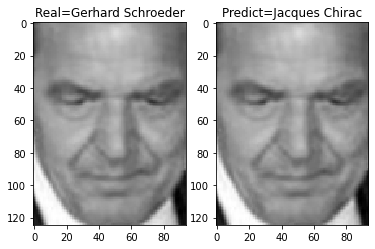

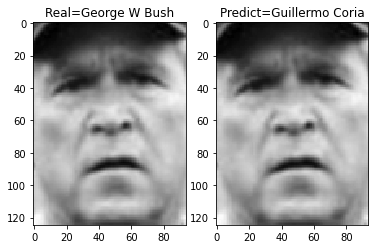

In [322]:
y_pred = clf.predict(X_test)

draw_picture(y_test, y_pred, n_pictures=2)

In [323]:
# Давайте сделаем алгоритм, который предсказывает самый популярный класс и посмотрим на то, что мы получим
from collections import Counter

cnt = Counter(y)
popular_cls = sorted(cnt.items(), reverse=True, key=lambda x: x[1])[0][0]

const_train = [popular_cls] * y_train.shape[0]
const_test = [popular_cls] * y_test.shape[0]

len(const_train), len(const_test)

(1896, 474)

Const model train score=0.2199367088607595
Const model test score=0.23839662447257384


<Figure size 360x576 with 0 Axes>

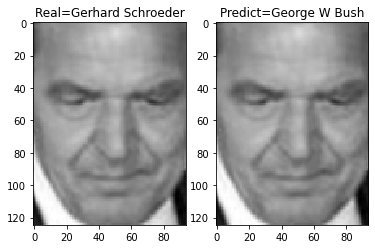

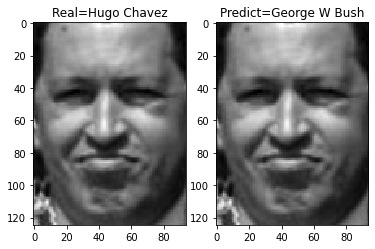

In [324]:
# Очевидно, что наша Логистическая регрессия намного лучше справляется с задачей, чем константный алгоритм. Значительный прогресс имеется!

print(f'Const model train score={accuracy_score(y_train, const_train)}')
print(f'Const model test score={accuracy_score(y_test, const_test)}')

draw_picture(y_test, const_test, n_pictures=2)

## С уменьшением размерности:

### SVD

In [335]:
from sklearn.decomposition import TruncatedSVD

In [336]:
print(f'Train={X_train.shape}, Test={X_test.shape}')
svd = TruncatedSVD(n_components=1896).fit(X_train)
X_train = svd.transform(X_train)
X_test_resize = svd.transform(X_test)

Train=(1896, 11750), Test=(474, 11750)


In [346]:
X_train.shape, X_test_resize.shape

((1896, 1896), (474, 1896))

In [345]:
Cs = [1, 2, 3, 10, 20, 50]
errors = []
for C in Cs:
    clf = LogisticRegression(C=C, class_weight='balanced')
    clf.fit(X_train, y_train)
    train_pred = clf.predict(X_train)
    test_pred = clf.predict(X_test_resize)
    errors.append((C, accuracy_score(y_test, test_pred), accuracy_score(y_train, train_pred)))
    
best_c, best_test, best_train = max(errors, key=lambda x: x[1])
clf = LogisticRegression(C=best_c)
print(clf.fit(X_train, y_train))
print(f'train accuracy={accuracy_score(y_train, clf.predict(X_train))}')
print(f'test accuracy={accuracy_score(y_test, clf.predict(X_test_resize))}')

LogisticRegression(C=3)
train accuracy=0.9678270042194093
test accuracy=0.6962025316455697


<Figure size 360x576 with 0 Axes>

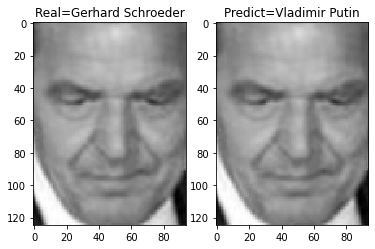

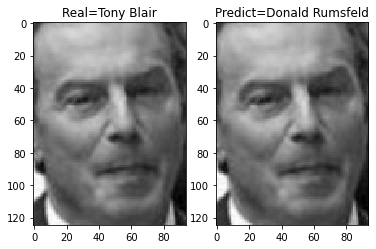

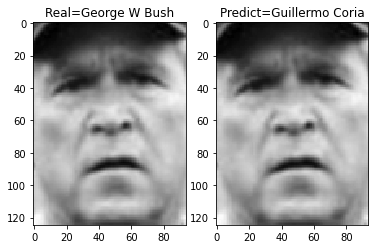

In [348]:
y_pred = clf.predict(X_test_resize)

draw_picture(y_test, y_pred, n_pictures=3)

Заметим, что время обучения уменьшилось практически в 8 раз при этом упал скор, но не особо сильно.

### PCA

In [349]:
from sklearn.decomposition import PCA